In [1]:
import numpy as np
import matplotlib.pyplot as plt
#H='/Users/hongwang/Downloads/plot_uq_erescale/noise_noiserescale/uq_noise_rescale_noiserescalr/'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
H='/content/drive/My Drive/galaxy_deblur/new_10k_data/dropout/'

In [4]:
!ls '/content/drive/My Drive/galaxy_deblur/new_10k_data/dropout/'

new_data_dropout_original_clamp.npz  uq_dropout_rescale_clamp
new_data_dropout_original.npz


In [5]:
#quadrature add
sadd = lambda x,y : np.sqrt(x**2+y**2)
def three_bins(q): # split quantity in three bins
    N=len(q)
    mlim1, mlim2 = np.sort(q)[[N//3, 2*N//3]]
    bin1 = np.where(q<=mlim1)
    bin2 = np.where((q>mlim1)&(q<=mlim2))
    bin3 = np.where((q>mlim2))
    return bin1,bin2,bin3

In [6]:
# True data
o = np.load(H+'new_data_dropout_original_clamp.npz')
## this one still has the old definition, so we need to calculate
#e1_pred = (o['Mu20_pred']-o['Mu02_pred'])/(o['Mu20_pred']+o['Mu02_pred'])
#e2_pred = (2*o['Mu11_pred'])/(o['Mu20_pred']+o['Mu02_pred'])
e1_pred = o['e1_pred']
e2_pred = o['e2_pred']
m00_pred = o['M00_pred']
m10_pred = o['M10_pred']
m01_pred = o['M01_pred']
                                          
# PSF
psf=np.load(H+"../new_data_kernel_clamp.npz")
psf_e1=psf['e1_kernel']
psf_e2=psf['e2_kernel']
psf_m00=psf['M00_kernel']
psf_m10=psf['M10_kernel']
psf_m01=psf['M01_kernel']
psf_e = sadd(psf_e1,psf_e2)
pbin1,pbin2,pbin3 = three_bins(psf_e)

In [7]:
## Let's get noise realizations
noise_e1 = []
noise_e2 = []
noise_m01 = []
noise_m10 = []
noise_m00 = []

In [8]:
for i in range(110):
    t_ = np.load(H+f'uq_dropout_rescale_clamp/results_dropout{i}.npz')
    noise_e1.append(t_['e1_pred'])
    noise_e2.append(t_['e2_pred'])
    noise_m10.append(t_['M10_pred'])
    noise_m01.append(t_['M01_pred'])
    noise_m00.append(t_['M00_pred'])
    if i==0:
        e1_true = t_['e1_true']
        e2_true = t_['e2_true']
        m10_true = t_['M10_true']
        m01_true = t_['M01_true']
        m00_true = t_['M00_true']
        mag = np.log10(t_['M00_true'])


In [9]:
e1_noise = np.array(noise_e1).T
e2_noise = np.array(noise_e2).T
m10_noise = np.array(noise_m10).T
m01_noise = np.array(noise_m01).T
m00_noise = np.array(noise_m00).T

## get around shitty values
#m20_noise[m20_noise<0] = np.NaN
#m02_noise[m02_noise<0] = np.NaN
#e1_noise = (m20_noise-m02_noise)/(m20_noise+m02_noise)
#e2_noise = (2*m11_noise)/(m20_noise+m02_noise)
print(np.shape(m10_noise))
m10_pred_avgnoise = m10_noise.mean(axis=1)
m01_pred_avgnoise = m01_noise.mean(axis=1)
m00_pred_avgnoise = m00_noise.mean(axis=1)
print(m10_pred_avgnoise.shape, m01_pred_avgnoise.shape, m00_pred_avgnoise.shape)

(10000, 110)
(10000,) (10000,) (10000,)


In [10]:
# let's make three mag bins.
mbin1, mbin2, mbin3 = three_bins(mag)

In [ ]:
print(e1_pred_avgnoise.min(),e1_pred_avgnoise.max())
print(e2_pred_avgnoise.min(),e2_pred_avgnoise.max())

assert (np.all(sadd(psf_e1,psf_e2)<1))
assert (np.all(sadd(e1_true,e2_true)<1))
assert (np.all(sadd(e1_pred,e2_pred)<1))
assert (np.all(sadd(e1_pred_avgnoise,e2_pred_avgnoise)<1))

In [11]:
## let us just ignore this issue and see if higher SNR have lower error
err_m10 = np.sqrt(np.var(m10_noise,axis=1))
err_m01 = np.sqrt(np.var(m01_noise,axis=1))
err_m00 = np.sqrt(np.var(m00_noise,axis=1))

[]

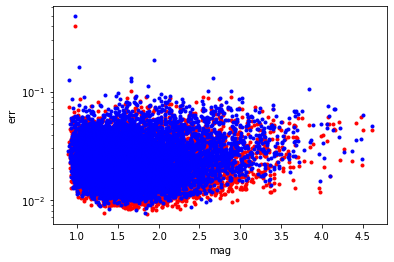

In [12]:
plt.plot(mag,err_m10,'r.')
plt.plot(mag,err_m01,'b.')
#plt.plot(mag,err_m00,'g.')
plt.xlabel('mag')
plt.ylabel('err')
plt.semilogy()

[]

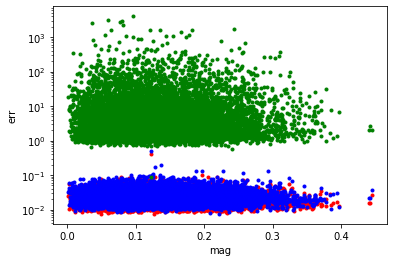

In [13]:
## is if PSF sizes affets

plt.plot(psf_e,err_m10,'r.')
plt.plot(psf_e,err_m01,'b.')
plt.plot(psf_e,err_m00,'g.')
plt.xlabel('mag')
plt.ylabel('err')
plt.semilogy()
## not really

#M10

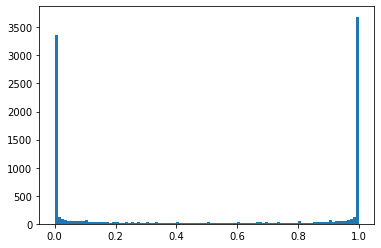

In [14]:
# now see where in cdf the truth lies. Ideally, this number should be distributed between 0 and 1.
cdfpos = np.array([np.sum(t<dist)/110 for t,dist in zip(m10_true,m10_noise)])
### all in all, way too many outliers
_=plt.hist(cdfpos, bins=100)

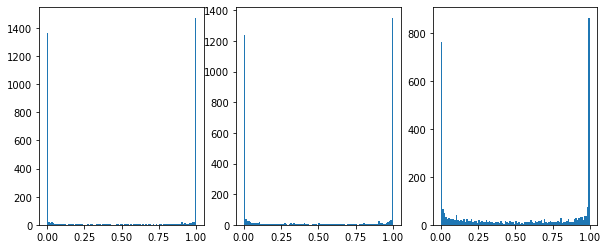

In [18]:
#split by mag bins
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
_=plt.hist(cdfpos[mbin1], bins=100)
plt.subplot(1,3,2)
_=plt.hist(cdfpos[mbin2], bins=100)
plt.subplot(1,3,3)
_=plt.hist(cdfpos[mbin3], bins=100)

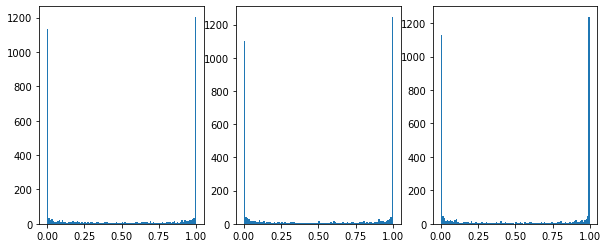

In [16]:
# same but for psf bins
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
_=plt.hist(cdfpos[pbin1], bins=100)
plt.subplot(1,3,2)
_=plt.hist(cdfpos[pbin2], bins=100)
plt.subplot(1,3,3)
_=plt.hist(cdfpos[pbin3], bins=100)

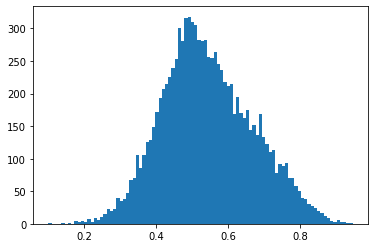

In [25]:
# do the same for predicted position. This should surely work
# For Guassian, it should around half
cdfposp = np.array([np.sum(t<dist)/110 for t,dist in zip(m10_pred,m10_noise)])
### all in all, way too many outliers
_=plt.hist(cdfposp, bins=94)

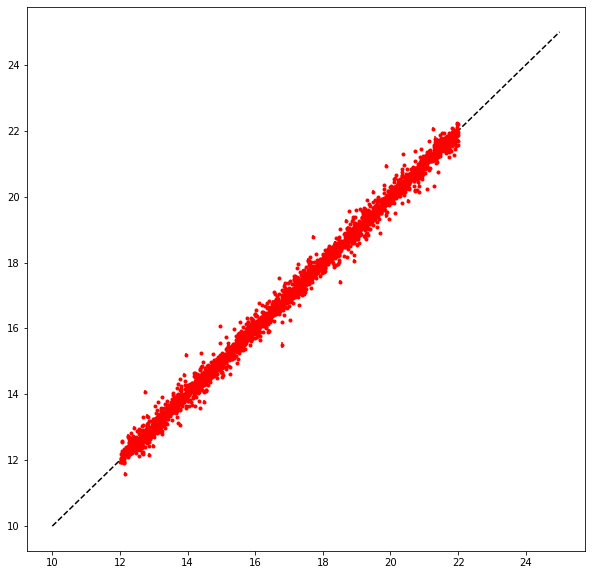

In [28]:
plt.figure(figsize=(10,10))
plt.errorbar(m10_true[mbin2],m10_pred[mbin2], yerr=err_m10[mbin2],fmt='r.')
plt.plot([10,25],[10,25],'k--')

#M01

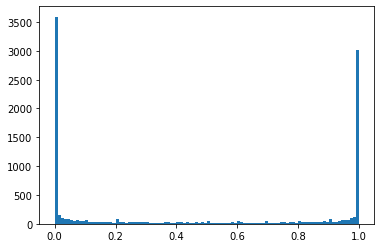

In [29]:
# now see where in cdf the truth lies. Ideally, this number should be distributed between 0 and 1.
cdfpos = np.array([np.sum(t<dist)/110 for t,dist in zip(m01_true,m01_noise)])
### all in all, way too many outliers
_=plt.hist(cdfpos, bins=100)

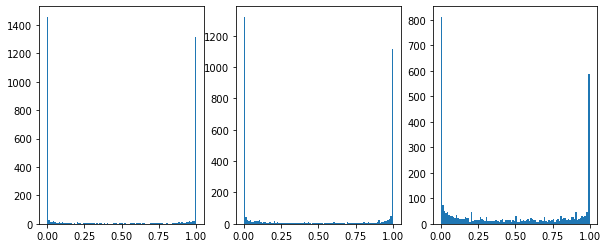

In [30]:
#split by mag bins
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
_=plt.hist(cdfpos[mbin1], bins=100)
plt.subplot(1,3,2)
_=plt.hist(cdfpos[mbin2], bins=100)
plt.subplot(1,3,3)
_=plt.hist(cdfpos[mbin3], bins=100)

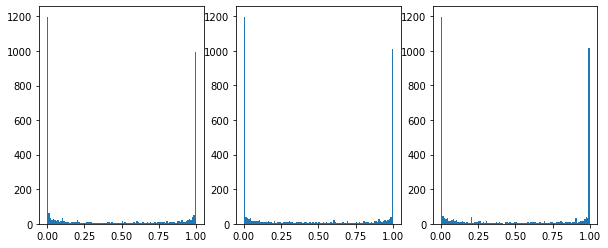

In [31]:
# same but for psf bins
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
_=plt.hist(cdfpos[pbin1], bins=100)
plt.subplot(1,3,2)
_=plt.hist(cdfpos[pbin2], bins=100)
plt.subplot(1,3,3)
_=plt.hist(cdfpos[pbin3], bins=100)

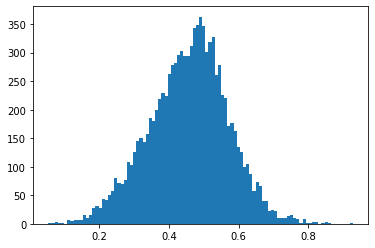

In [35]:
# do the same for predicted position. This should surely work
# For Guassian, it should around half
cdfposp = np.array([np.sum(t<dist)/110 for t,dist in zip(m01_pred,m01_noise)])
### all in all, way too many outliers
_=plt.hist(cdfposp, bins=97)

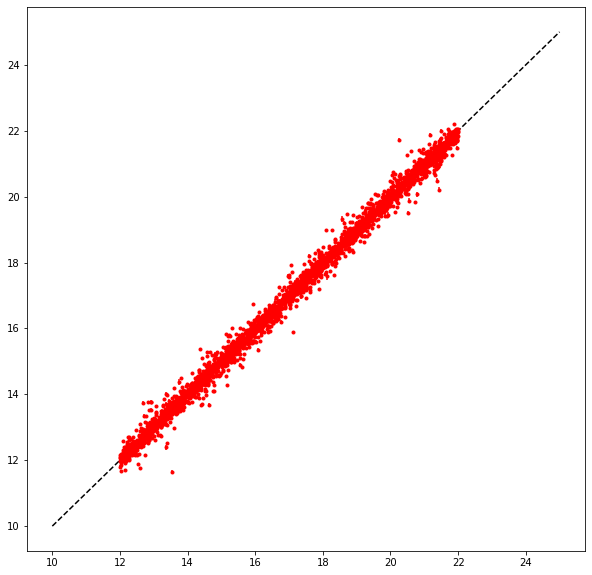

In [36]:
plt.figure(figsize=(10,10))
plt.errorbar(m01_true[mbin2],m01_pred[mbin2], yerr=err_m01[mbin2],fmt='r.')
plt.plot([10,25],[10,25],'k--')

#M00

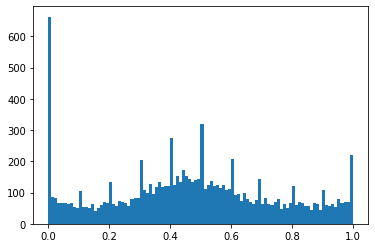

In [39]:
# now see where in cdf the truth lies. Ideally, this number should be distributed between 0 and 1.
cdfpos = np.array([np.sum(t<dist)/110 for t,dist in zip(m00_true,m00_noise)])
### all in all, way too many outliers
_=plt.hist(cdfpos, bins=100)

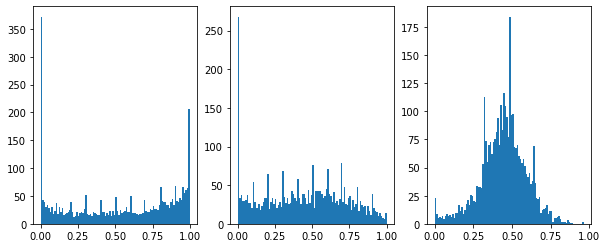

In [40]:
#split by mag bins
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
_=plt.hist(cdfpos[mbin1], bins=100)
plt.subplot(1,3,2)
_=plt.hist(cdfpos[mbin2], bins=100)
plt.subplot(1,3,3)
_=plt.hist(cdfpos[mbin3], bins=100)

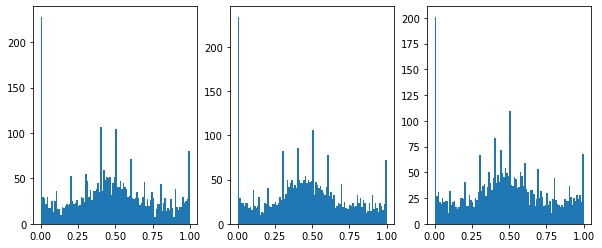

In [41]:
# same but for psf bins
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
_=plt.hist(cdfpos[pbin1], bins=100)
plt.subplot(1,3,2)
_=plt.hist(cdfpos[pbin2], bins=100)
plt.subplot(1,3,3)
_=plt.hist(cdfpos[pbin3], bins=100)

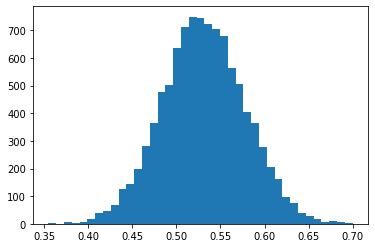

In [53]:
# do the same for predicted position. This should surely work
# For Guassian, it should around half
cdfposp = np.array([np.sum(t<dist)/110 for t,dist in zip(m00_pred,m00_noise)])
### all in all, way too many outliers
_=plt.hist(cdfposp, bins=39)

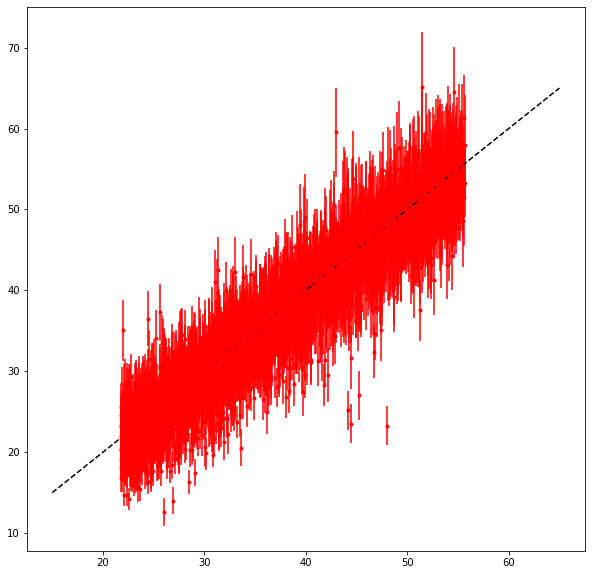

In [55]:
plt.figure(figsize=(10,10))
plt.errorbar(m00_true[mbin2],m00_pred[mbin2], yerr=err_m00[mbin2],fmt='r.')
plt.plot([15,65],[15,65],'k--')